In [1]:
# Some doubts arose while making this notebook:

# 27/12/2021:
# For the Moonley-Rivlin model, some sources suggest that the Invariants (i1 and i2) are from the
# Left Cauchy-Green Deformation Tensor 'B'. In this notebook, I used C because I came to the conclusion that
# B = C if F is symmetrical, and this would facilitate differenciation to get the 2nd Second Piola Kirchoff Stresses.
# For different loads (biaxial or triaxial) would I need to use B? Or should I just rotate F into its principal orientation?

# 28/12/2021:
# I was a little bit confused by this, but I think I have understood now: the invariants of B and C are the same! Made a notebook showing this.

# I still don't clearly see why the Cauchy stress in xx and zz directions is not zero if the load is uniaxial.
# (cauchy [0,0] != 0)



# I will in another notebook use this model for a biaxial load and then try to account for compressibility.
# I am also trying to compute other relevant tensors using sympy

In [ ]:
import pandas as pd
import random
import sympy as sym
import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

In [31]:
def mooney_rivlin_uniaxial(params, stretch):
    #returns cauchy stress at yy direction
    
    # Right Cauchy-Green Deformation Tensor 'C'
    C11 = sym.Symbol('C11')
    C12 = sym.Symbol('C12')
    C13 = sym.Symbol('C13')
    C21 = sym.Symbol('C21')
    C22 = sym.Symbol('C22')
    C23 = sym.Symbol('C23')
    C31 = sym.Symbol('C31')
    C32 = sym.Symbol('C32')
    C33 = sym.Symbol('C33')
    C = sym.Matrix([[C11,C12,C13], [C21,C22,C23], [C31,C32,C33]])  
    
    # Compute the invariants I1 and I2 of the tensor C
    i1=sym.trace(C)
    i2 = C11*C22 + C22*C33 + C33*C11 - C12**2 - C23**2 - C31**2
    
    #Generate SEF (Strain Energy Function)
    #symbolic C10 and C01
    c10s = sym.Symbol('c10s')
    c01s = sym.Symbol('c01s')
    sef=c10s*(i1-3) + c01s*(i2-3)
    #Second Piola Kirchoff Stresses
    S11=2*sym.diff(sef,C11)
    S12=2*sym.diff(sef,C12)
    S13=2*sym.diff(sef,C13)
    S21=2*sym.diff(sef,C21)
    S22=2*sym.diff(sef,C22)
    S23=2*sym.diff(sef,C23)
    S31=2*sym.diff(sef,C31)
    S32=2*sym.diff(sef,C32)
    S33=2*sym.diff(sef,C33)
    S = sym.Matrix([[S11,S12,S13], [S21,S22,S23], [S31,S32,S33]])
    
    #Deformation Gradient assuming incompressibility and a uniaxial load
    F=sym.Matrix([[1/(np.sqrt(stretch)),0,0], [0,stretch,0], [0,0,1/(np.sqrt(stretch))]])
    Ft=sym.transpose(F)
    C=Ft*F
    Jac=sym.det(F) # is allways 1 because we have assumed incompressibility
    C11v=C[0,0]
    C12v=C[0,1]
    C13v=C[0,2]
    C21v=C[1,0]
    C22v=C[1,1]
    C23v=C[1,2]
    C31v=C[2,0]
    C32v=C[2,1]
    C33v=C[2,2]
    
    cauchy=(1/Jac)*(F*S*Ft)
    stress=cauchy[1,1]-cauchy[0,0]
    stress_abq=sym.Matrix([[0,0,0], [0, stress,0], [0,0,0]]) 
    s22_val=stress_abq.subs([(C11, C11v), (C12, C12v), 
                                  (C13, C13v),(C21, C21v), 
                                  (C22, C22v), (C23, C23v),
                                  (C31, C31v), (C32, C32v), 
                                  (C33, C33v),(c10s,params[0]), (c01s,params[1])])
    
    return stretch,s22_val[1,1]

def get_curve(params,stretch_min,stretch_max,ninc):
    #stores Mooney-Rivlin uniaxial runs between minimum and a maximum stretch
    lst=[mooney_rivlin_uniaxial(params, stretch) for stretch in np.linspace(stretch_min,stretch_max,ninc)]
    return lst

In [3]:
#Initial data-----------------------------------------------------------------------------------------------------

C10min=0.1     #min C10 value
C10max=10.0    #max C10 value
C01min=0.1     #min C01 value
C01max=2.0     #max C01 value
decimals=2   #number of decimal cases of C10 and C01 variables

n_c10=5               #number of C10 variables
n_c01=5               #number of C01 variables
n = n_c10 * n_c01     #number of combinations
#
st_max=3.0             #applied stretch
st_min=1.0
ninc=100        #number of stretch increments
#------------------------------------------------------------------------------------------------------------------

In [4]:
# Generates random values for c10 and c01
c10_list = np.round(np.random.uniform(C10min, C10max, size=(n_c10, 1)), decimals)
c01_list = np.round(np.random.uniform(C01min, C01max, size=(n_c01, 1)), decimals)
params = np.array([])

# Computes the n combinations of c10 and c01 values
for i in c10_list:
    for j in c01_list:
        params = np.append(params, np.array([i,j]))
params = params.reshape(-1, 2)

In [5]:
# Append the combinations to a DataFrame

df = pd.DataFrame(params[:,0], columns = ['c10'])
df['c01'] = params[:,1]
df

# Later I will deal with duplicates

,c10,c01
0,2.86,1.23
1,2.86,0.28
2,2.86,0.97
3,2.86,0.73
4,2.86,0.88
5,8.79,1.23
6,8.79,0.28
7,8.79,0.97
8,8.79,0.73
9,8.79,0.88


In [7]:
#generate (x,y) data for each unique c10 at the dataframe
df['data']=df.apply(lambda x : get_curve(x,st_min,st_max,ninc), axis=1)
df

,c10,c01,data
0,2.86,1.23,"[(1.0, 0), (1.02020202020202, 0.49287099447018..."
1,2.86,0.28,"[(1.0, 0), (1.02020202020202, 0.37998465633141..."
2,2.86,0.97,"[(1.0, 0), (1.02020202020202, 0.46197578613746..."
3,2.86,0.73,"[(1.0, 0), (1.02020202020202, 0.43345713229188..."
4,2.86,0.88,"[(1.0, 0), (1.02020202020202, 0.45128129094537..."
5,8.79,1.23,"[(1.0, 0), (1.02020202020202, 1.21175472122669..."
6,8.79,0.28,"[(1.0, 0), (1.02020202020202, 1.09886838308793..."
7,8.79,0.97,"[(1.0, 0), (1.02020202020202, 1.18085951289398..."
8,8.79,0.73,"[(1.0, 0), (1.02020202020202, 1.15234085904840..."
9,8.79,0.88,"[(1.0, 0), (1.02020202020202, 1.17016501770189..."


In [20]:
example = np.array(df.data[15])

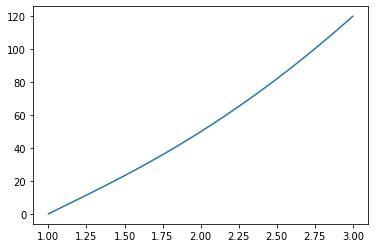

In [21]:
y = example[:, 1]
x = example[:, 0]
plt.plot(x,y)

In [11]:
df.to_pickle('./data.pkl')

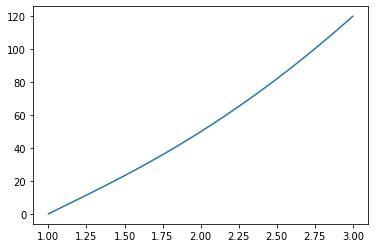

In [22]:
# Just to manually check that the lambda function worked properly
check = np.array(get_curve([6.52,1.23],st_min,st_max,ninc))
plt.plot(check[:,0],check[:,1])